In [1]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, pipeline
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
class DepthLoss:
    def __init__(self, device) -> None:
        # self.image_processor = AutoImageProcessor.from_pretrained('LiheYoung/depth-anything-small-hf')
        self.model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf").to(device)
        self._mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1).to(device)
        self._std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1).to(device)
        
    def convert_depth_to_disparity(self, depth):
        """
        Convert depth to disparity.
        input:
            depth: Nx1xHxW tensor
        output:
            disparity: Nx1xHxW tensor"""
        disparity = 1 / (depth + 1e-6)
        N, _, H, W = disparity.shape
        t = torch.median(disparity.reshape(N,H*W), dim=1).values.reshape(N, 1, 1, 1)
        s = torch.sum(torch.abs(disparity - t), dim=(1, 2, 3), keepdim=True) / (disparity.shape[2] * disparity.shape[3])
        disparity = (disparity - t) / s
        return disparity

    def transform(self, img):
        """
        input img: [0, 1], NxCxHxW tensor
        1. resize img to (518, 518)
        2. normalize img to mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        output:
            img: NxCxHxW tensor"""
        img = torch.nn.functional.interpolate(img, size=(518, 518), mode='bicubic', align_corners=False)
        img = (img - self._mean) / self._std
        return img

    def calculate_depth(self, img, return_disparity=True):
        """
        Calculate depth from an image.
        input: 
            img: NxCxHxW tensor
        output:
            depth: Nx1xHxW tensor"""
        # rescale img to [0, 255.0]
        with torch.no_grad():
            # convert img from [-1, 1] to [0, 1]
            # assert img.min() >= -1.0 and img.max() <= 1.0
            img = (img + 1) /2
            img = torch.clamp(img, 0, 1.0)
            inputs = self.transform(img)
            outputs = self.model(inputs)
            predicted_depth = outputs.predicted_depth
            prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),
                                                    size=img.shape[2:],
                                                    mode='bicubic',
                                                    align_corners=False)
            if not return_disparity:
                return prediction
            # convert depth to disparity and rescale with zero translation and unit scale
            disparity = self.convert_depth_to_disparity(prediction)
            
        return disparity
    
    def calculate_loss(self, img, depth):
        """
        Calculate depth loss.
        input:
            img: NxCxHxW tensor
            depth: Nx1xHxW tensor
        output:
            loss: scalar"""
        with torch.no_grad():
            predicted_disparity = self.calculate_depth(img)
        generated_disparity = self.convert_depth_to_disparity(-depth)
        loss = torch.nn.functional.l1_loss(predicted_disparity, generated_disparity)
        return loss

In [4]:
image_processor = AutoImageProcessor.from_pretrained('LiheYoung/depth-anything-small-hf')
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

(1024, 1024)


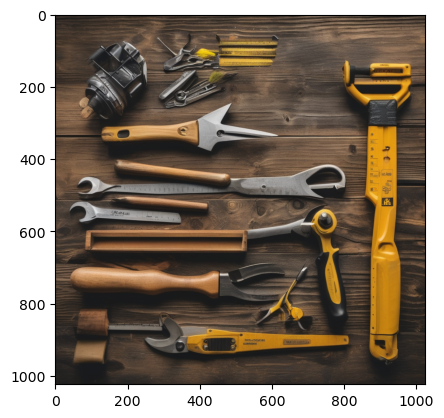

In [3]:
img_path='/storage2/guangrun/qijia_3d_model/depth_anything/n02966687_0004.png'
depth_path='/storage2/guangrun/qijia_3d_model/depth_anything/n02966687_0004_depth.png'
cache_dir='/storage2/guangrun/qijia_3d_model/huggingface/'
img = Image.open(img_path)

plt.imshow(img)
print(img.size)

In [5]:
images = torch.from_numpy(np.array(img)).unsqueeze(0).permute(0, 3, 1, 2)
print(images.shape)
images = torch.concat([images, images, images, images], dim=0).float()
print(images.shape)
print(images.dtype)
print(images.min(), images.max())

torch.Size([1, 3, 1024, 1024])
torch.Size([4, 3, 1024, 1024])
torch.float32
tensor(0.) tensor(255.)


dict_keys(['pixel_values'])
(1024, 1024)


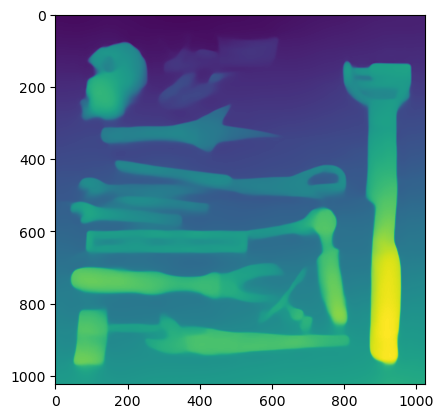

In [39]:
with torch.no_grad():
    # convert img from [-1, 1] to [0, 255.0]
    
    images = torch.clamp(images, 0, 255.0)
    inputs = image_processor(images=images, return_tensors='pt')
    print(inputs.keys())
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),
                                            size=images.shape[2:],
                                            mode='bicubic',
                                            align_corners=False)
depth=prediction[0].squeeze().cpu().numpy()
print(depth.shape)
plt.imshow(depth)
plt.show()

(1024, 1024)


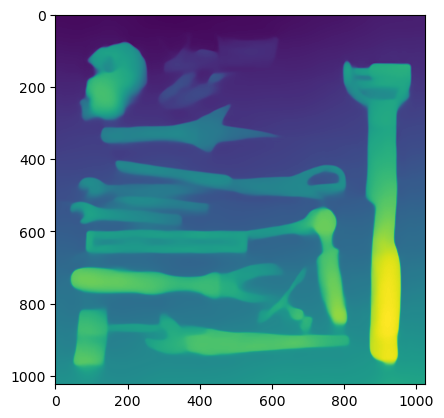

In [12]:
depth_loss = DepthLoss(device='cuda')
prediction = depth_loss.calculate_depth(images.cuda()*2/255.-1, return_disparity=False)
depth=prediction[3].squeeze().cpu().numpy()
print(depth.shape)
plt.imshow(depth)
plt.show()

In [51]:
inputs = image_processor(images=images, return_tensors="pt")
print(inputs['pixel_values'].shape)

torch.Size([4, 3, 518, 518])


In [52]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

In [53]:
print(predicted_depth.shape)
prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),
                                                size=img.size[::-1],
                                                mode='bicubic',
                                                align_corners=False)
print(prediction.shape)

torch.Size([4, 518, 518])
torch.Size([4, 1, 1024, 1024])


(1024, 1024)


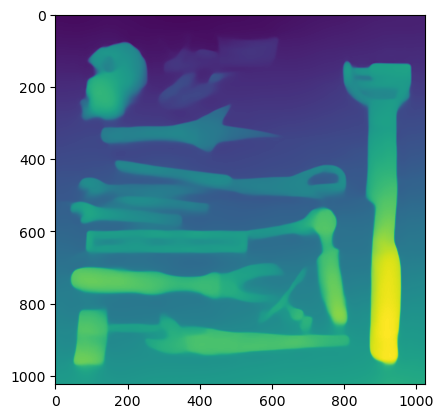

In [27]:
depth=prediction[0].squeeze().cpu().numpy()
print(depth.shape)
plt.imshow(depth)
plt.show()

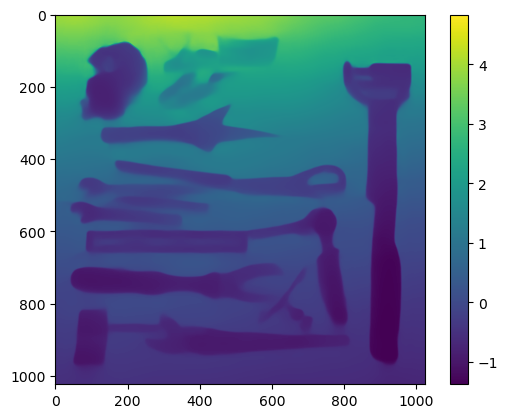

In [49]:
disparity = 1 / (depth + 1e-6)
# normalize disparity
t = np.median(disparity)
s = 1 / np.prod(disparity.shape) * np.sum(np.abs(disparity - t))
disparity = (disparity - t) / s
plt.imshow(disparity)
plt.colorbar()
plt.show()

In [ ]:
from torchvision.transforms import Compose, Resi
def preprocess_image(img):
    transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])


(1024, 1024)


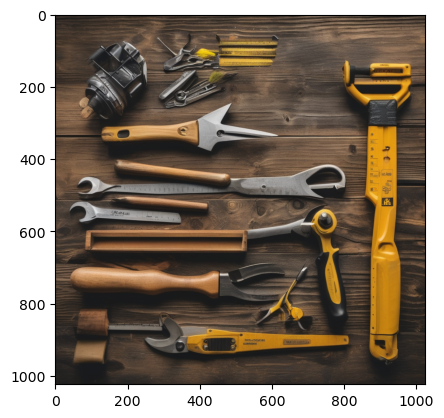

In [5]:
images = torch.from_numpy(np.array(img)).unsqueeze(0).permute(0, 3, 1, 2)
print(images.shape)
images = torch.concat([images, images, images, images], dim=0)
print(images.shape)

torch.Size([1, 3, 1024, 1024])
torch.Size([4, 3, 1024, 1024])


ValueError: Incorrect format used for image. Should be an url linking to an image, a base64 string, a local path, or a PIL image.

In [13]:
print(prediction.shape)
print(predicted_depth.shape)

torch.Size([4, 1, 1024, 1024])
torch.Size([4, 1022, 1022])


4 torch.Size([1, 1, 1024, 1024])


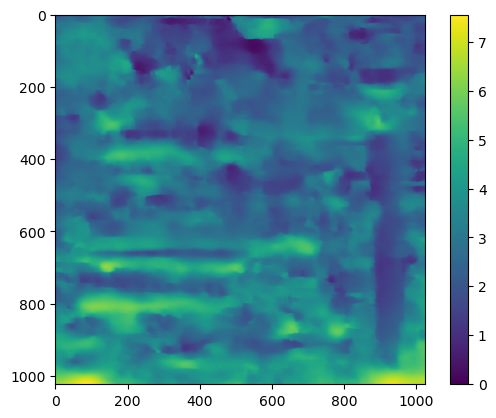

In [16]:
output = prediction.cpu().split(1)
print(len(output), output[0].shape)
plt.imshow(output[1].numpy().squeeze())
plt.colorbar()
plt.show()

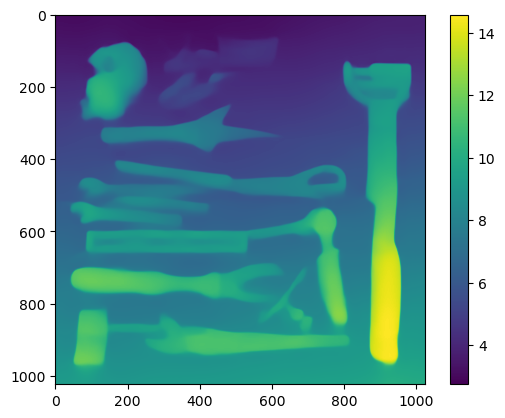

In [4]:
inputs = image_processor(images=img, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

prediction = torch.nn.functional.interpolate(predicted_depth.unsqueeze(1),
                                                size=img.size[::-1],
                                                mode='bicubic',
                                                align_corners=False)
output = prediction.cpu().numpy().squeeze()
plt.imshow(output)
plt.colorbar()
plt.show()

In [49]:
a = torch.randn(4, 5)
a
torch.median(a, 1)

torch.return_types.median(
values=tensor([ 0.0309, -0.9910,  0.3974, -0.7201]),
indices=tensor([3, 3, 4, 3]))

In [50]:
torch.median(a, 1).values

tensor([ 0.0309, -0.9910,  0.3974, -0.7201])